In [1]:
from src import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
import warnings
warnings.filterwarnings('ignore')

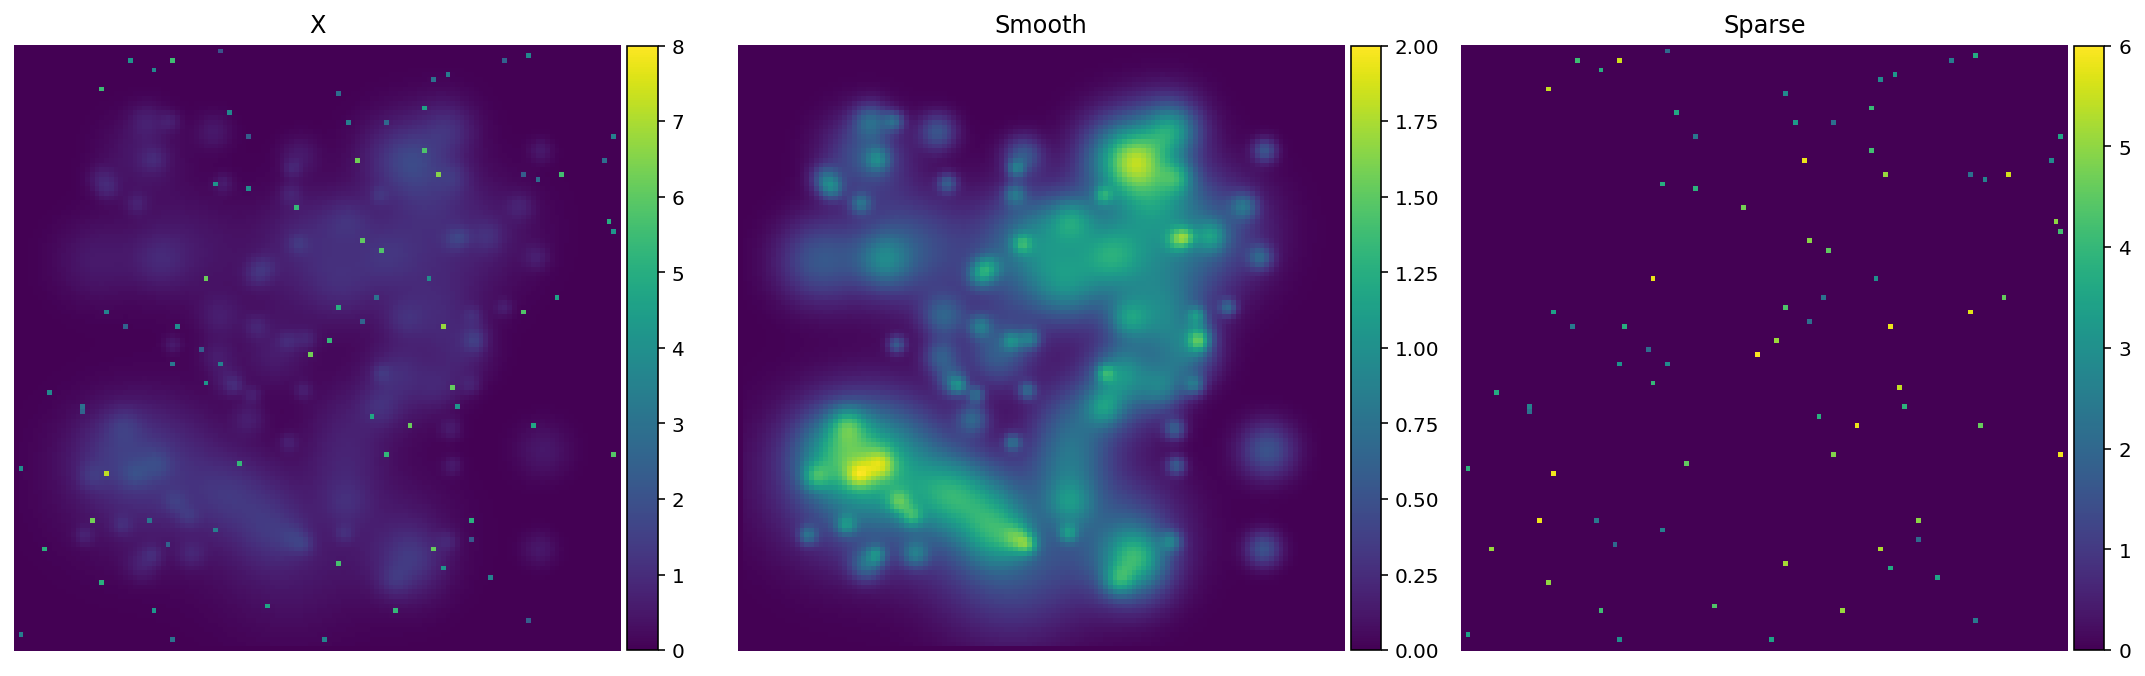

In [3]:
d = (128, 128)
seed = 42
s = SparseSmoothSignal(d)
s.random_sparse(seed)
s.random_smooth(seed)
s.plot()

In [4]:
L = 0.1
l1 = 0.02
l2 = 0.04
psnr = 50.
s.psnr = psnr
s.H = get_low_freq_operator(d, L)

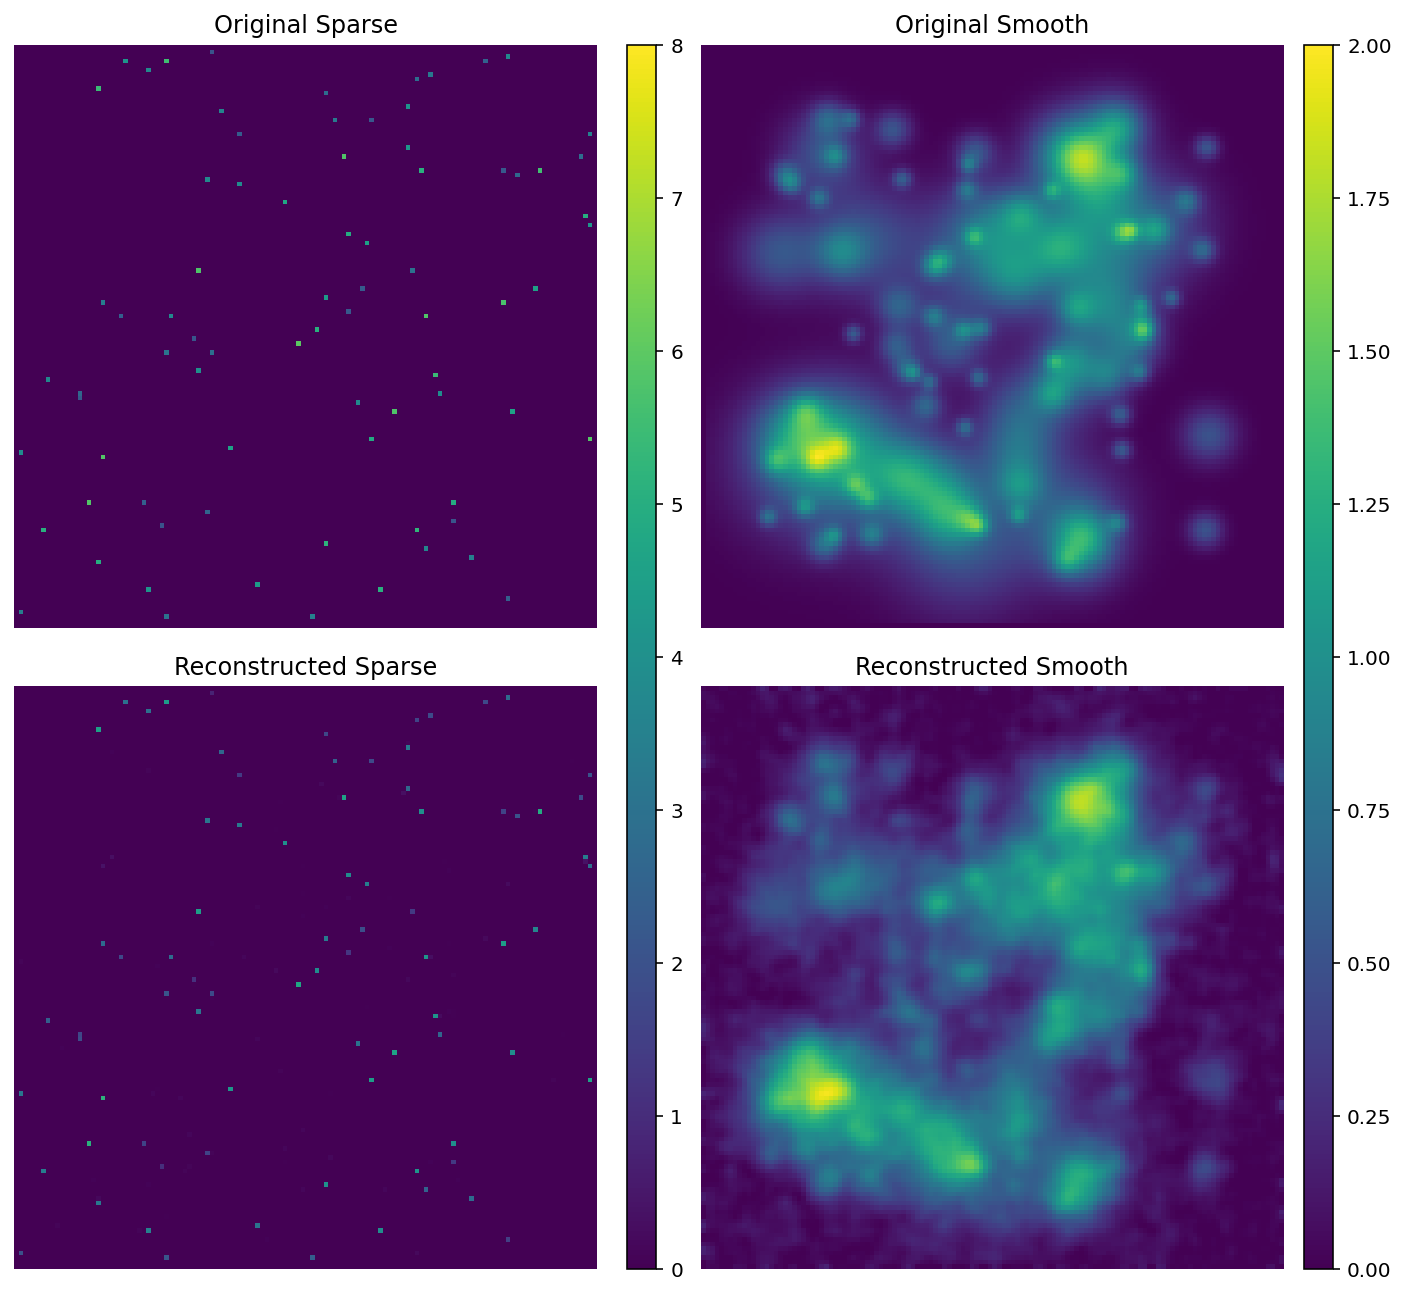

In [5]:
x1, x2 = solve(s, l1, l2, get_L2_operator(d, "Laplacian"))
plot_reconstruction(s.sparse, s.smooth, x1, x2)

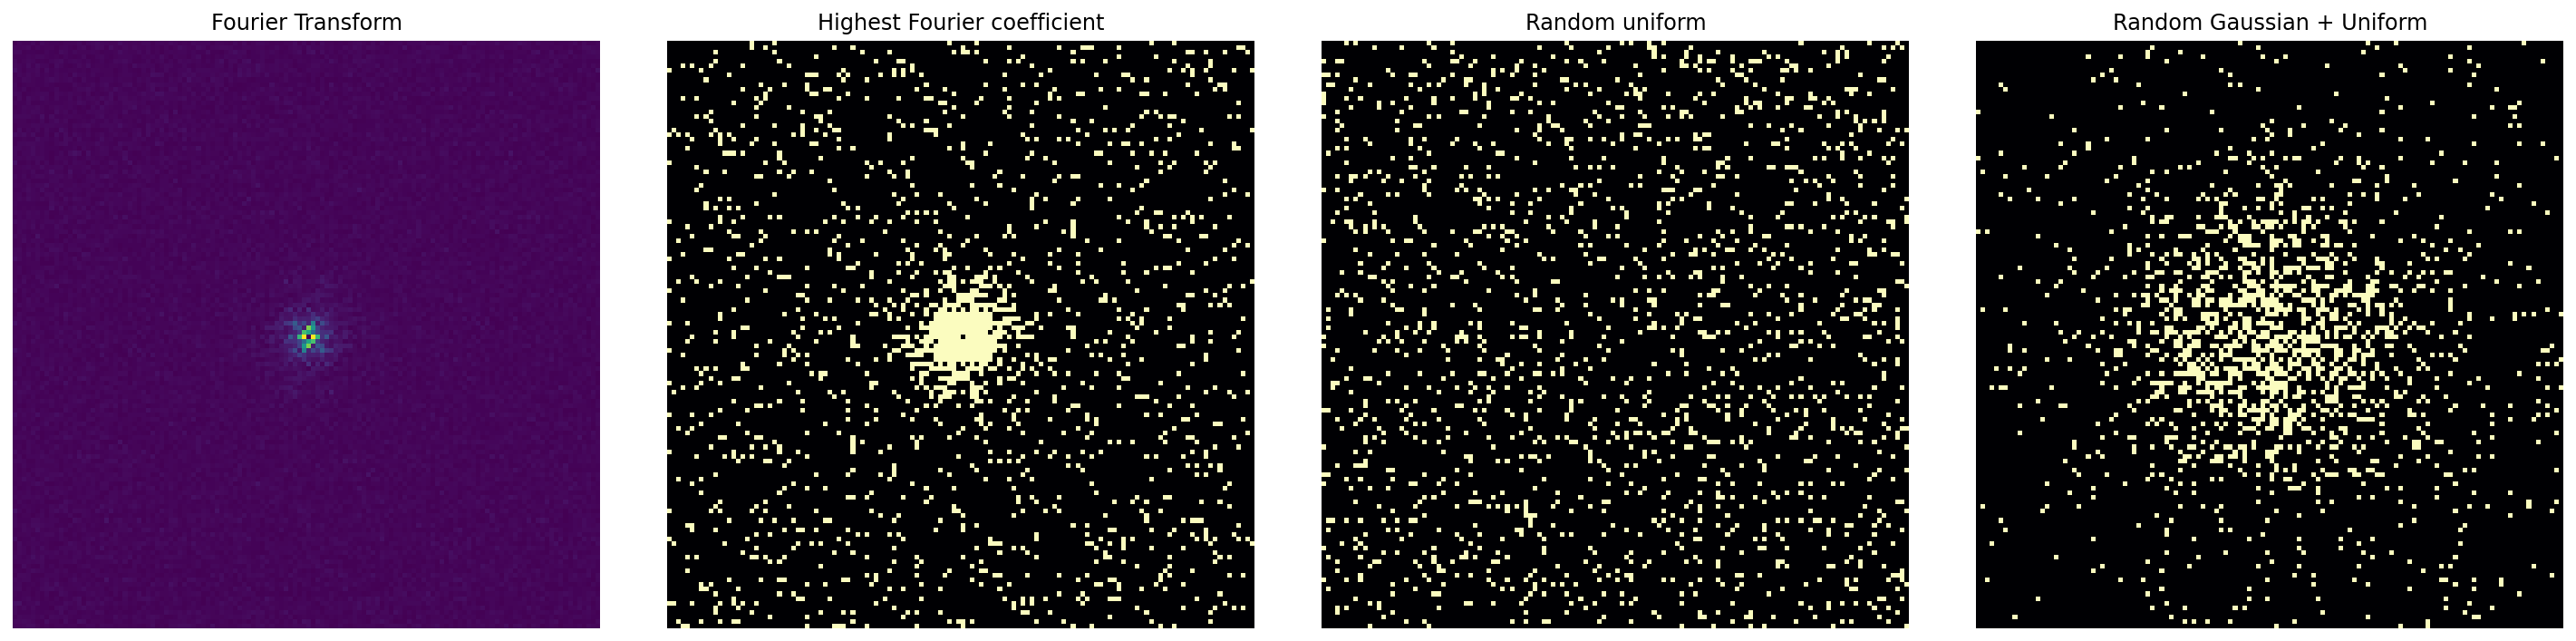

In [6]:
plot_sampling_methods(s, L)

Mean intensity of the reconstructed peaks (Highest Fourier coefficient) : 83.8%
Mean intensity of the reconstructed peaks (Random uniform) : 89.4%
Mean intensity of the reconstructed peaks (Random Gaussian + Uniform) : 70.9%


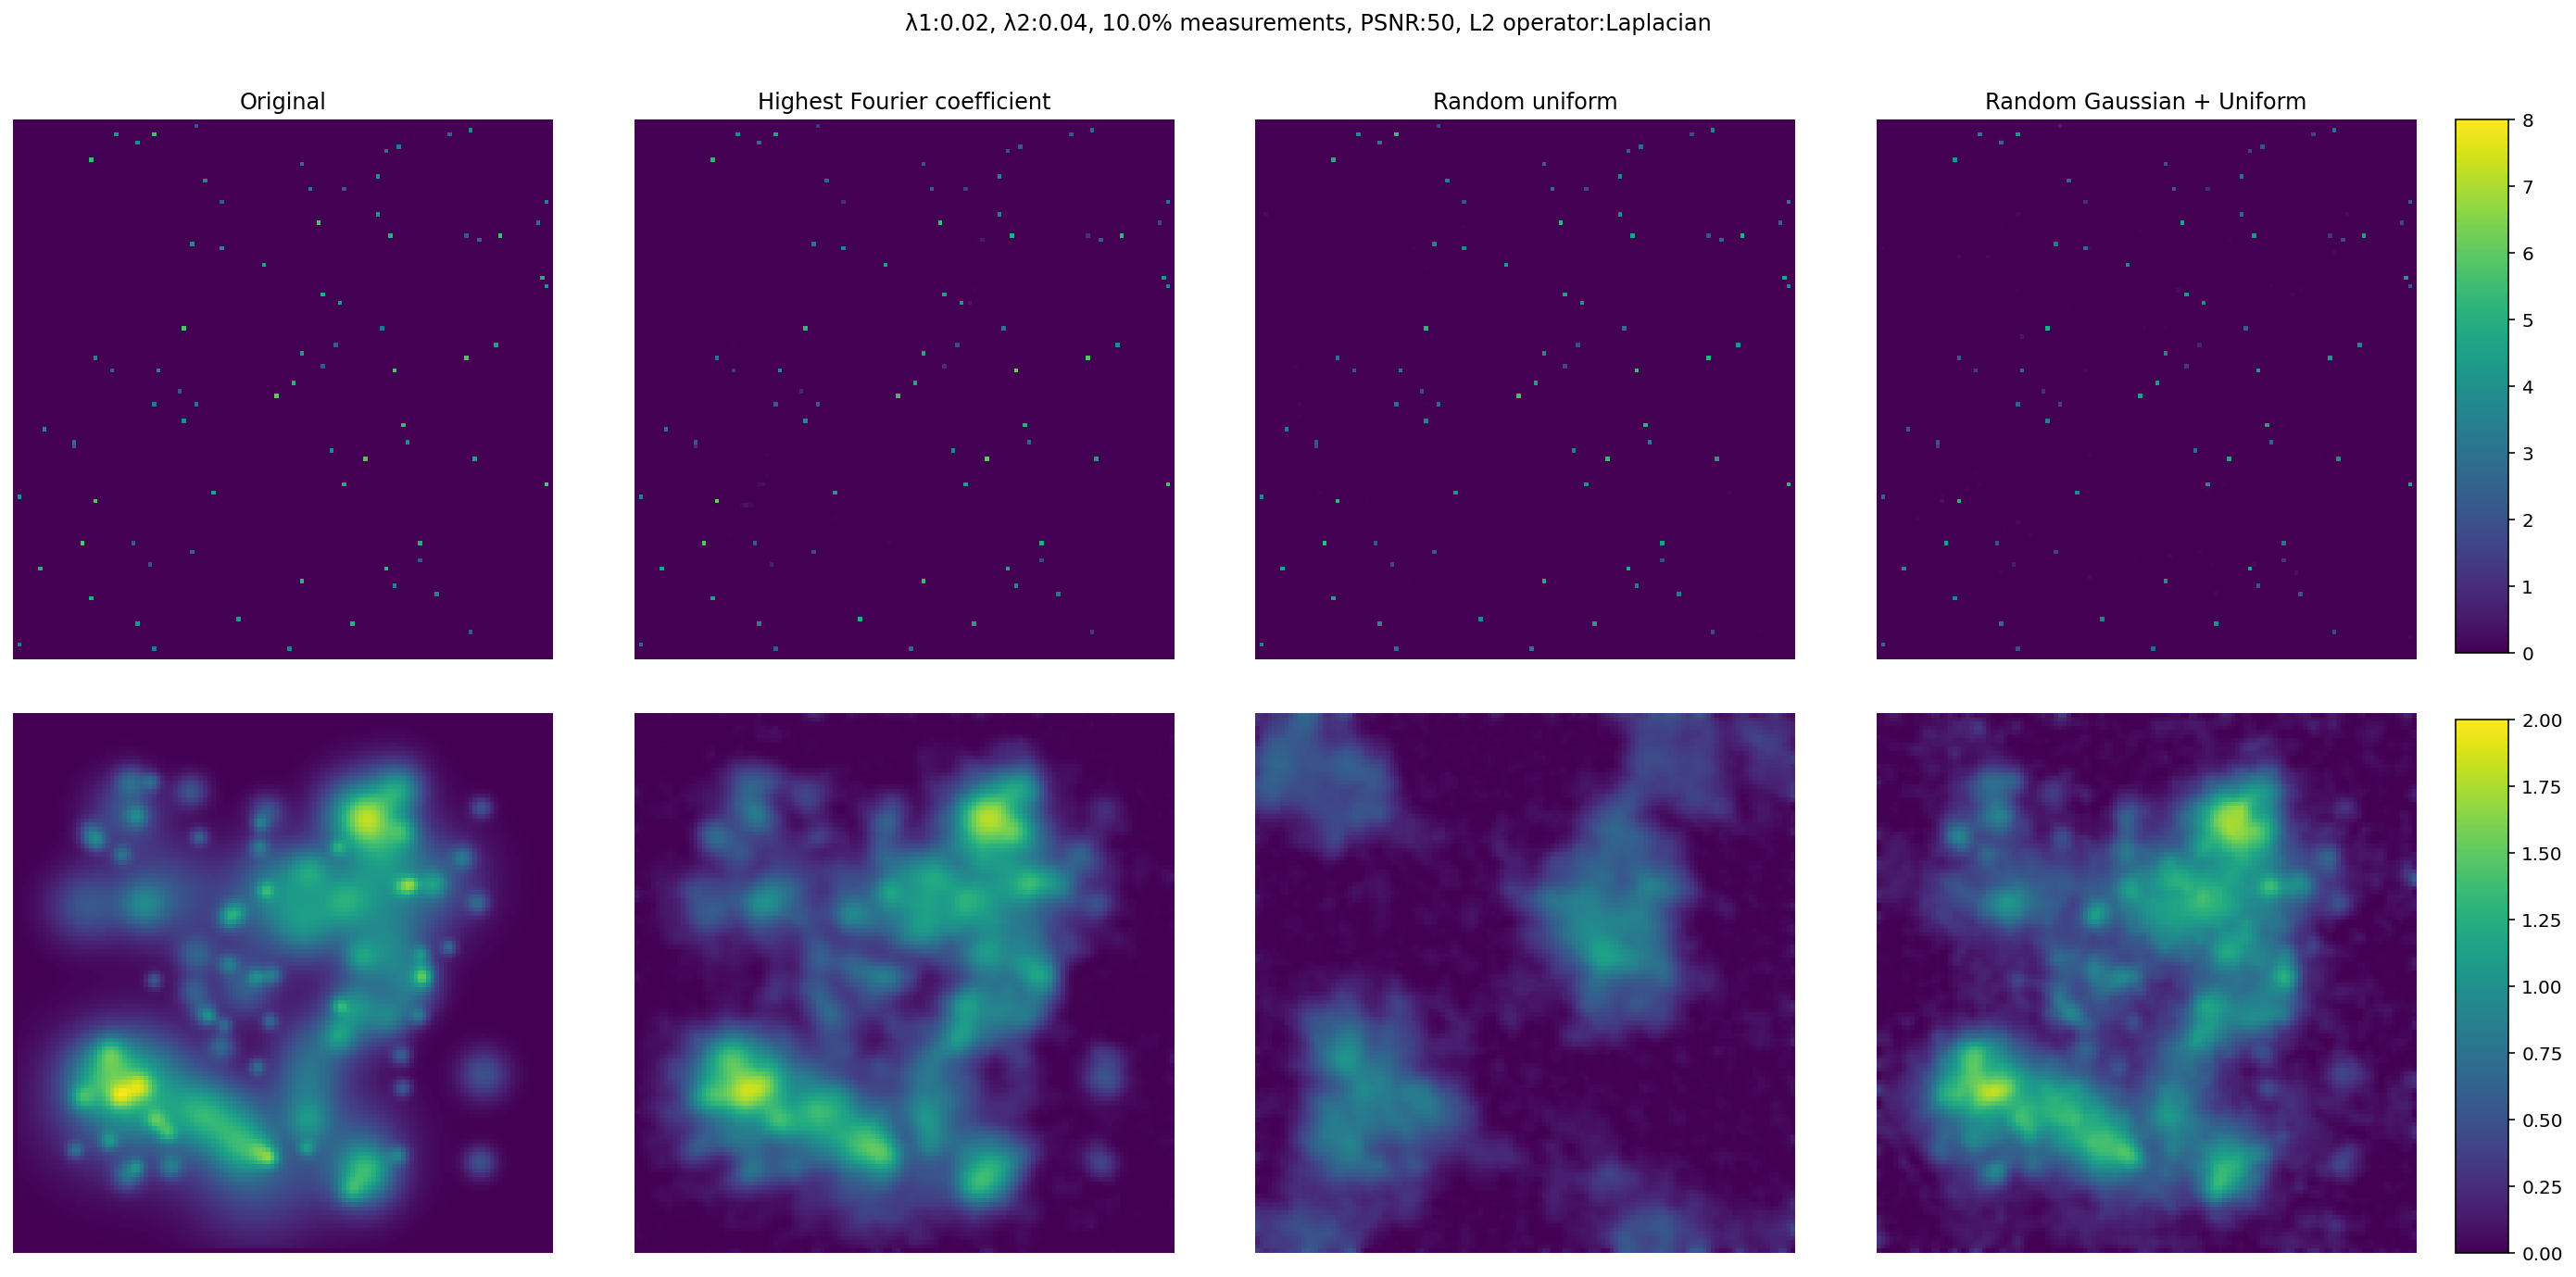

In [7]:
compare_measurements_methods(s, L, l1, l2, psnr, "Laplacian")

Mean intensity of the reconstructed peaks (Highest Fourier coefficient) : 84.5%
Mean intensity of the reconstructed peaks (Random uniform) : 90.1%
Mean intensity of the reconstructed peaks (Random Gaussian + Uniform) : 72.1%


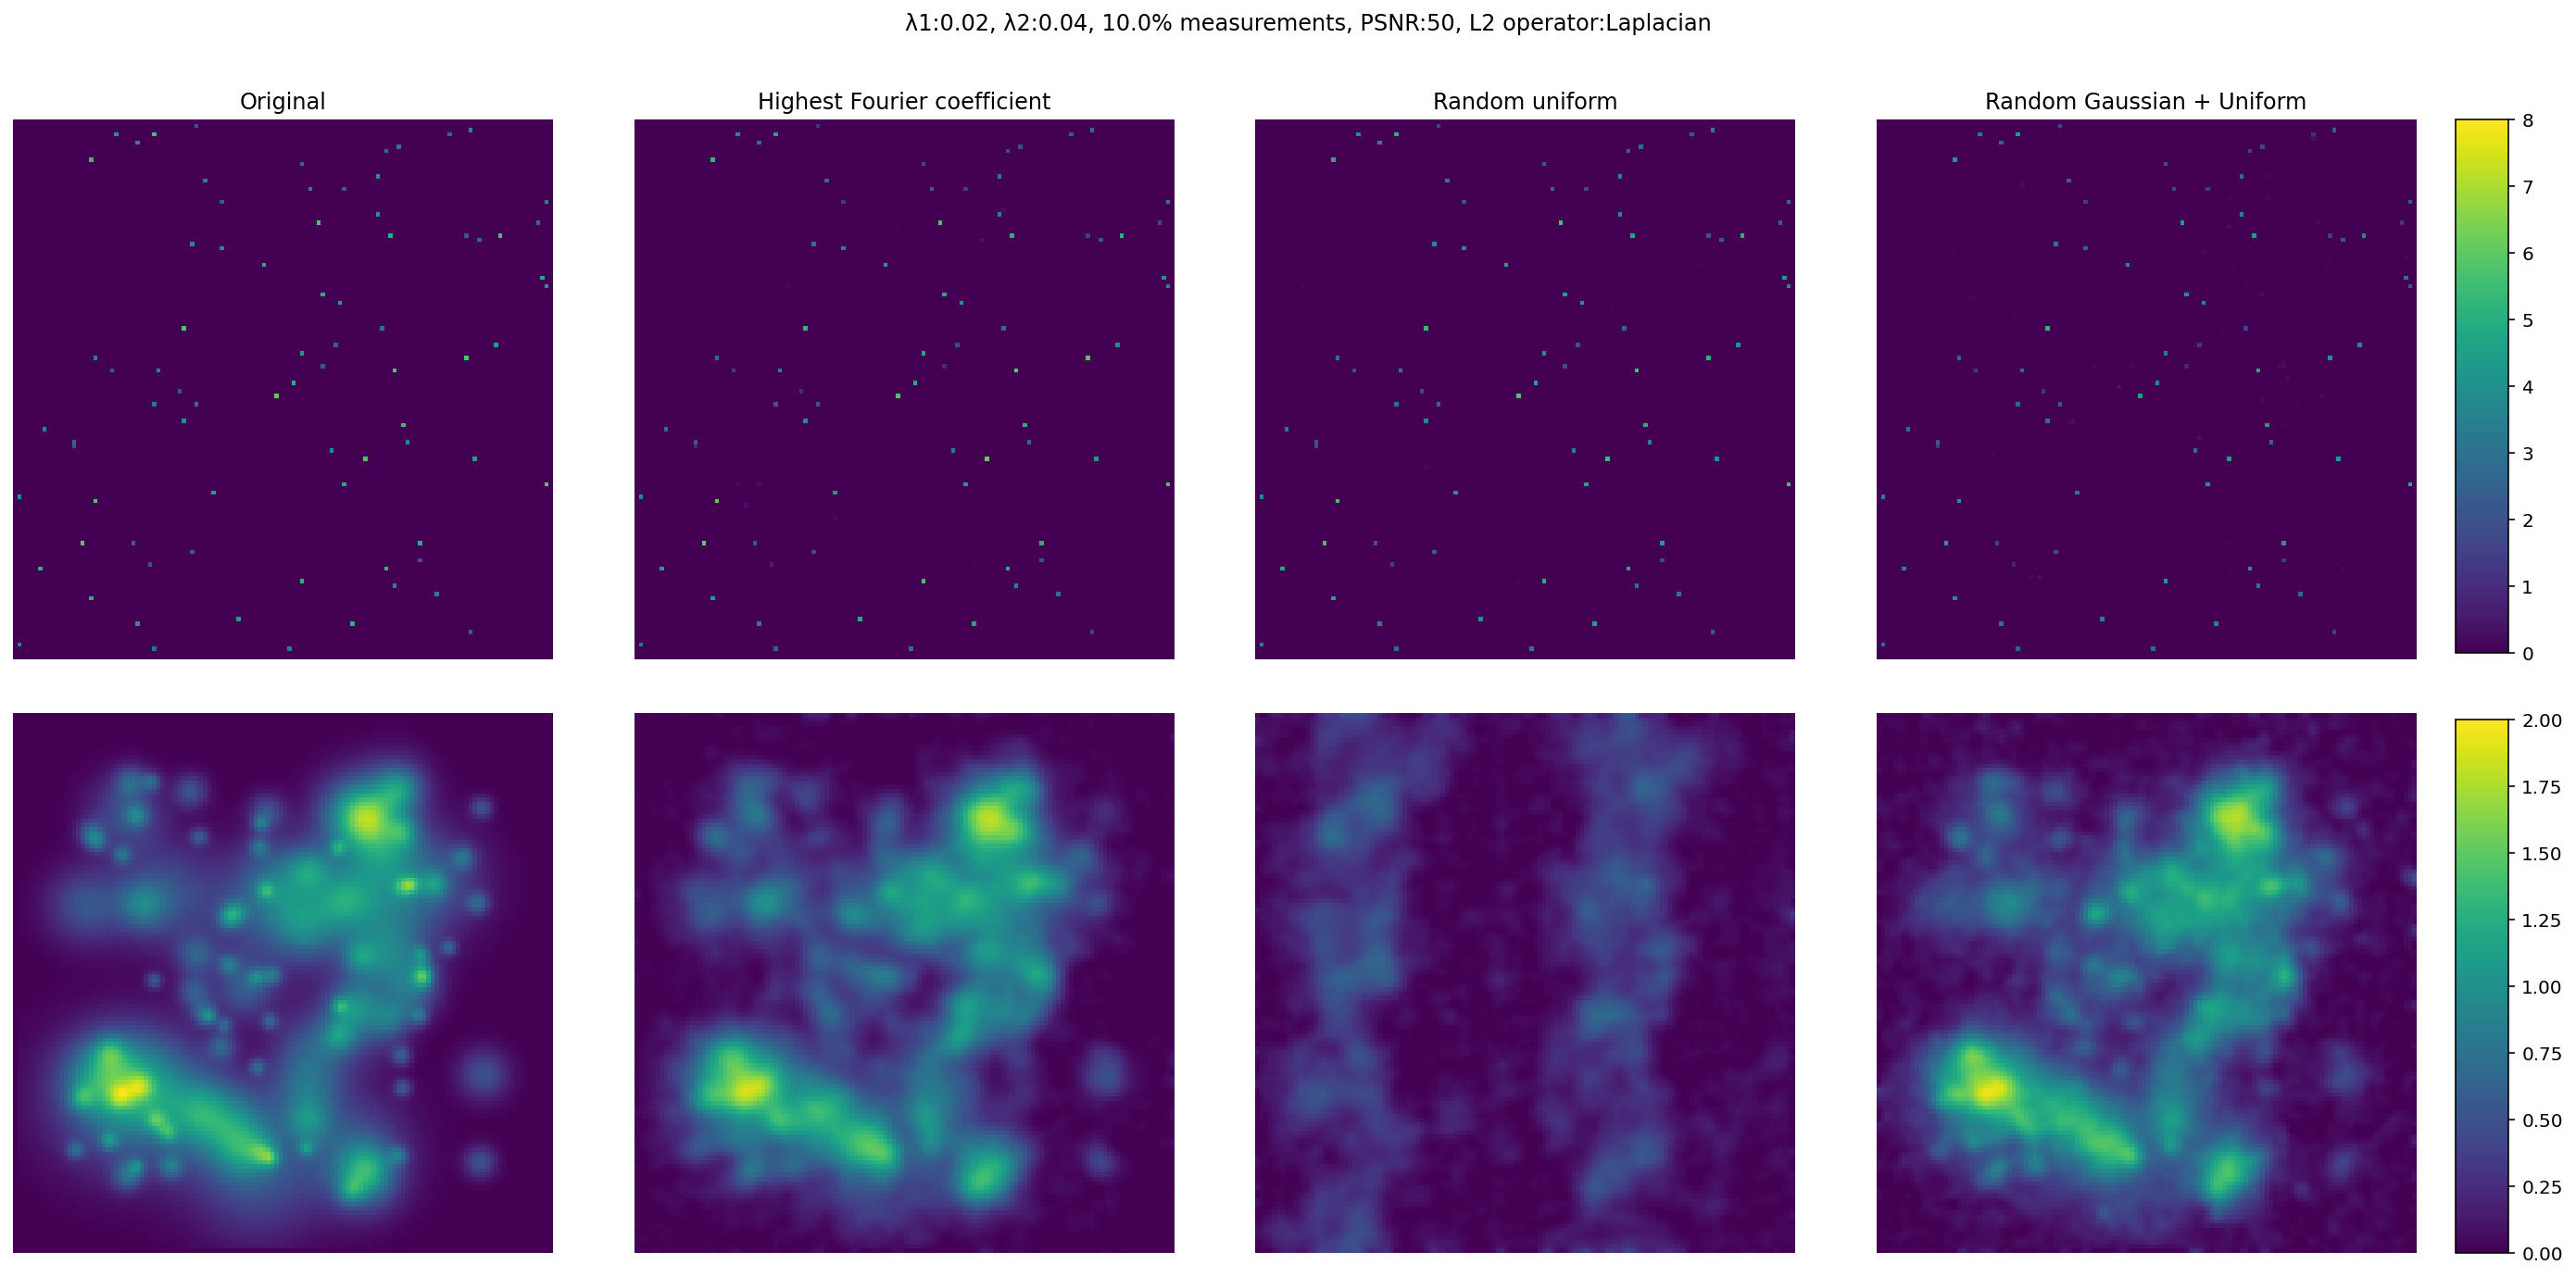

In [8]:
s.psnr = 20.
compare_measurements_methods(s, L, l1, l2, psnr, "Laplacian")

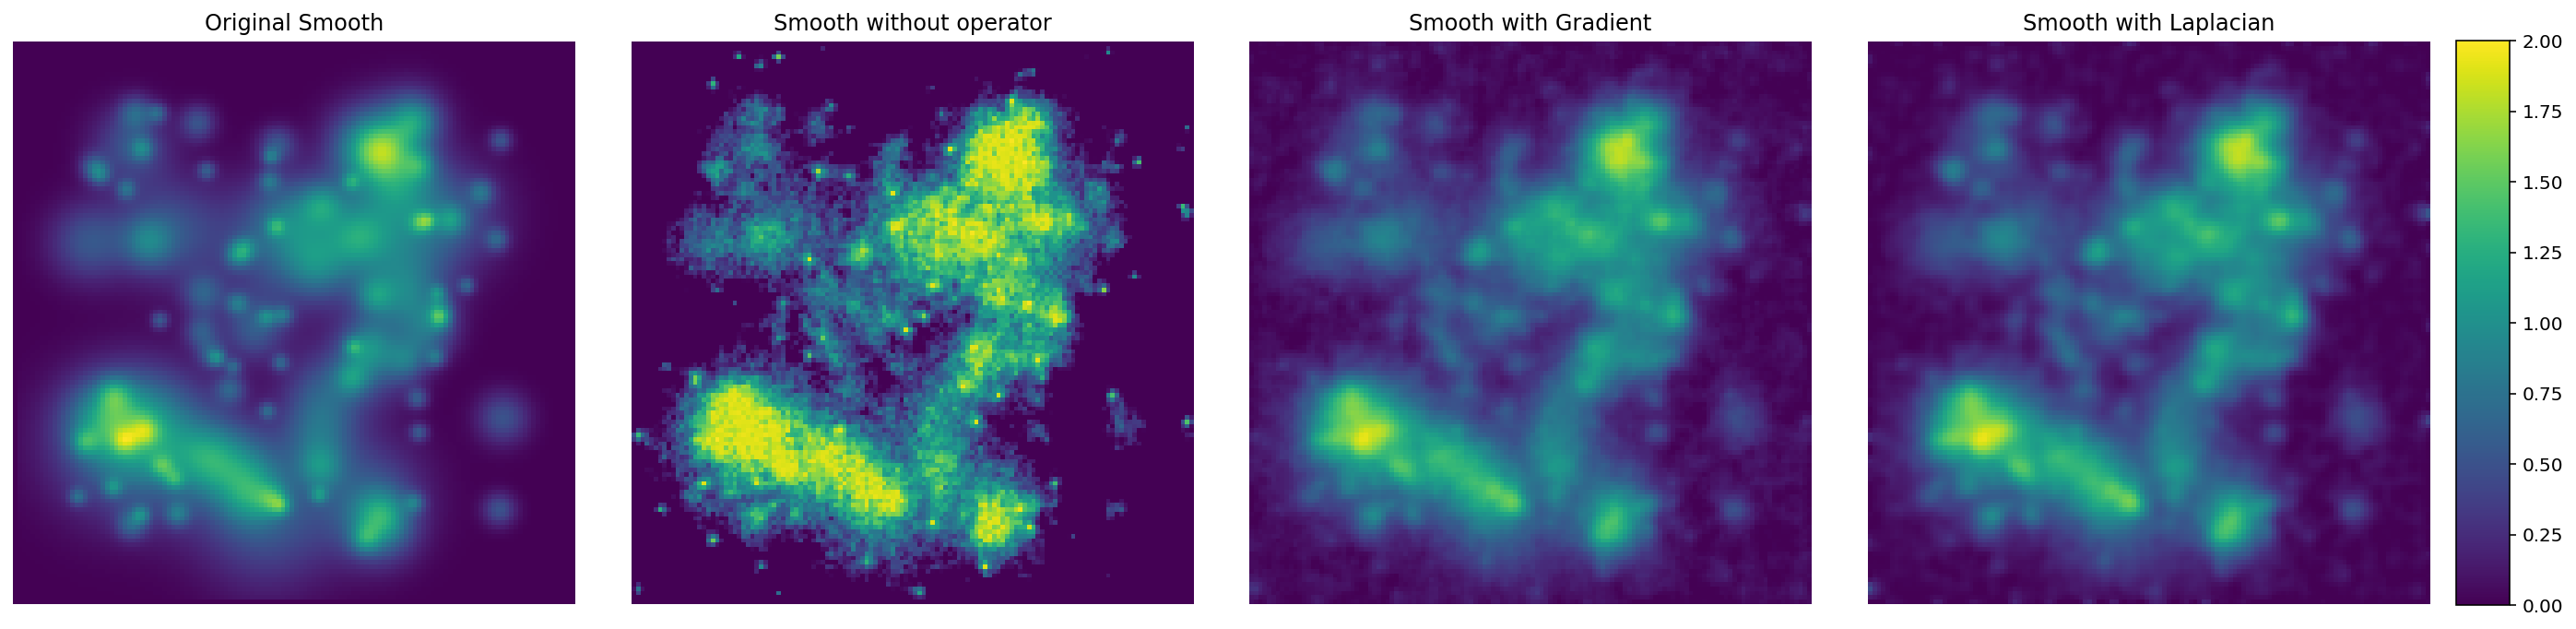

In [9]:
s.psnr = 50.
compare_smoothing_operator(s)

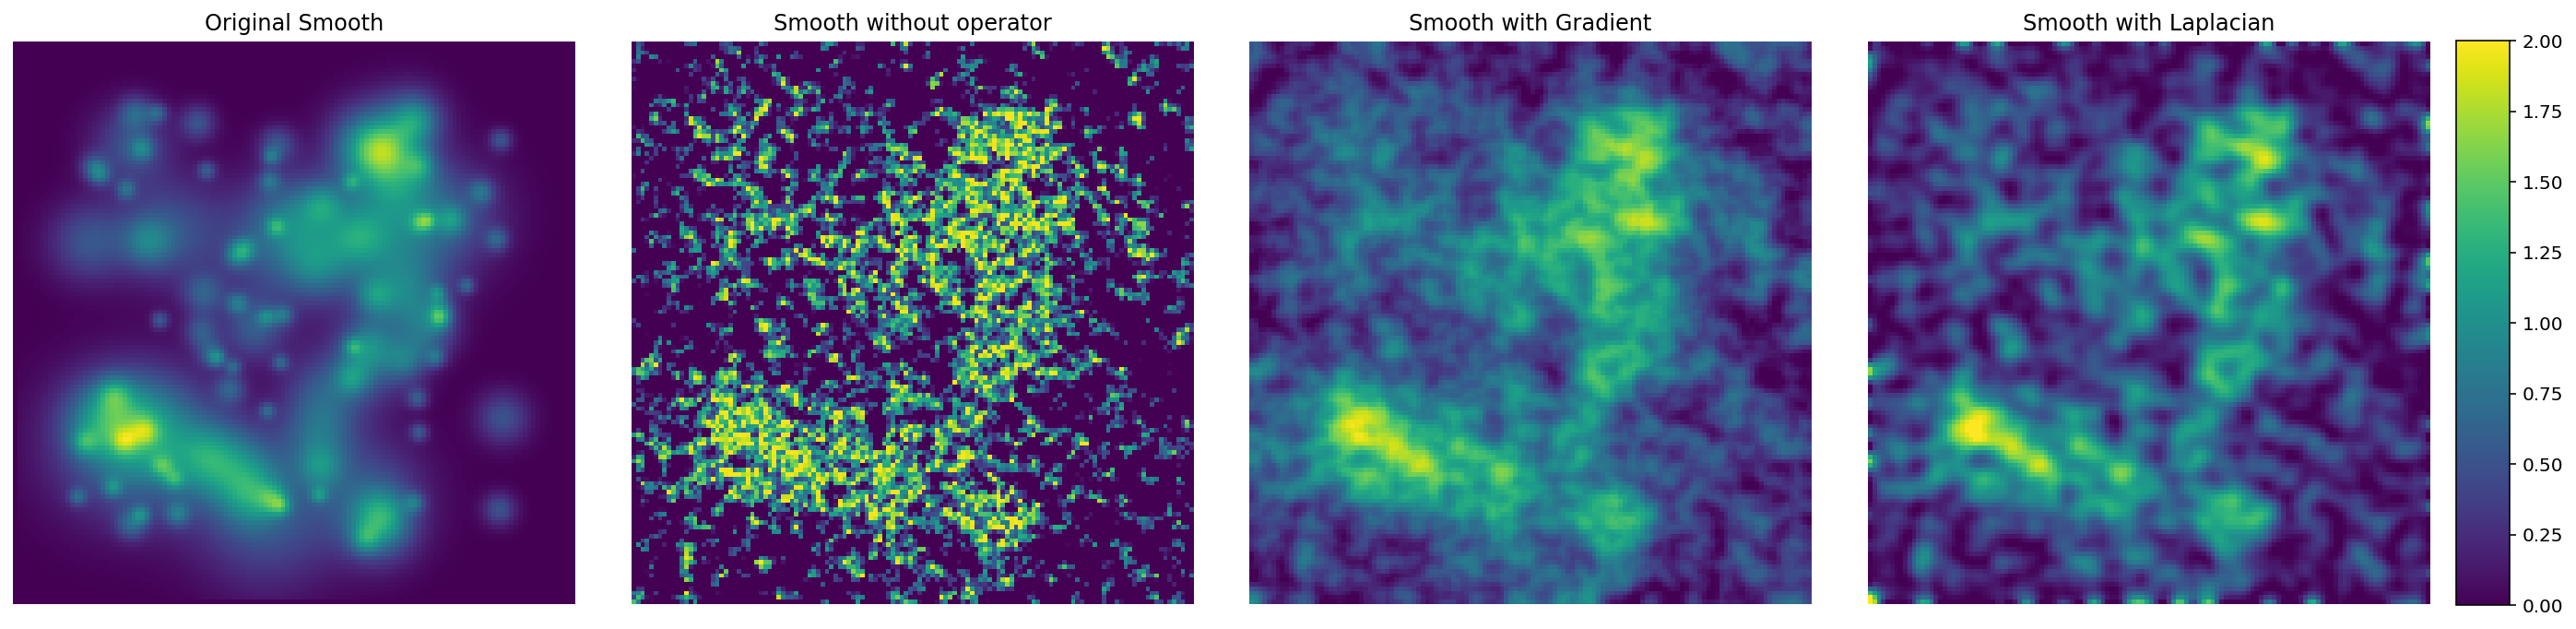

In [10]:
s.psnr = 20.
compare_smoothing_operator(s)

Best value for L1 penalty: 0.021306122448979593
Best value for L2 penalty: 0.009122448979591836


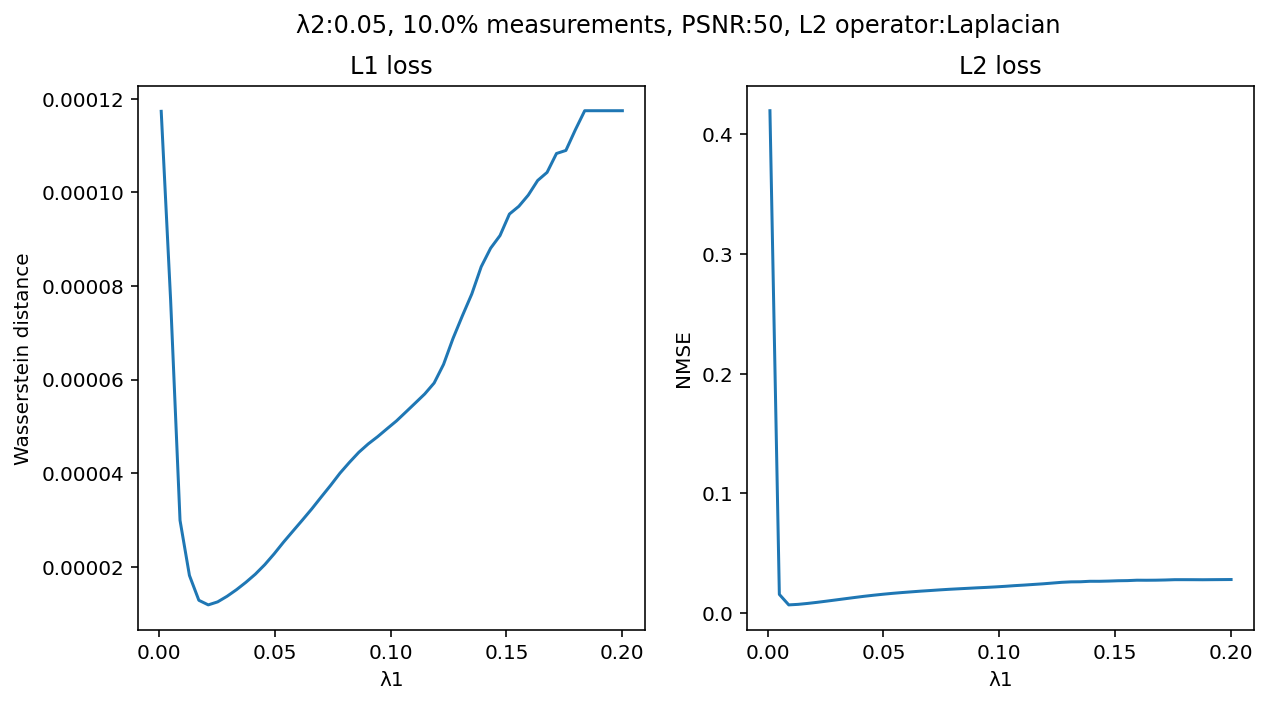

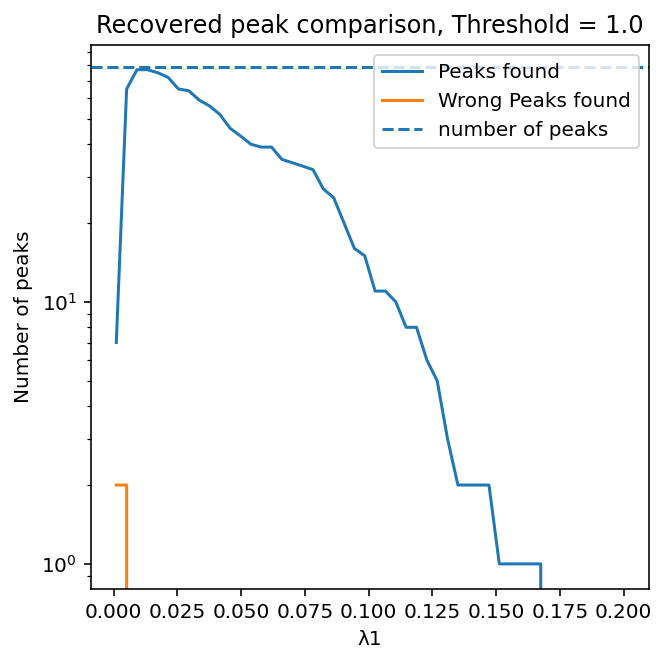

In [11]:
test_lambda1(s, L, lambda1_min=0.001, lambda1_max=0.2, nb=50, lambda2=0.05, operator_l2="Laplacian", psnr=50.)

Best value L1: 0.041612244897959186
Best value L2: 0.10659183673469388


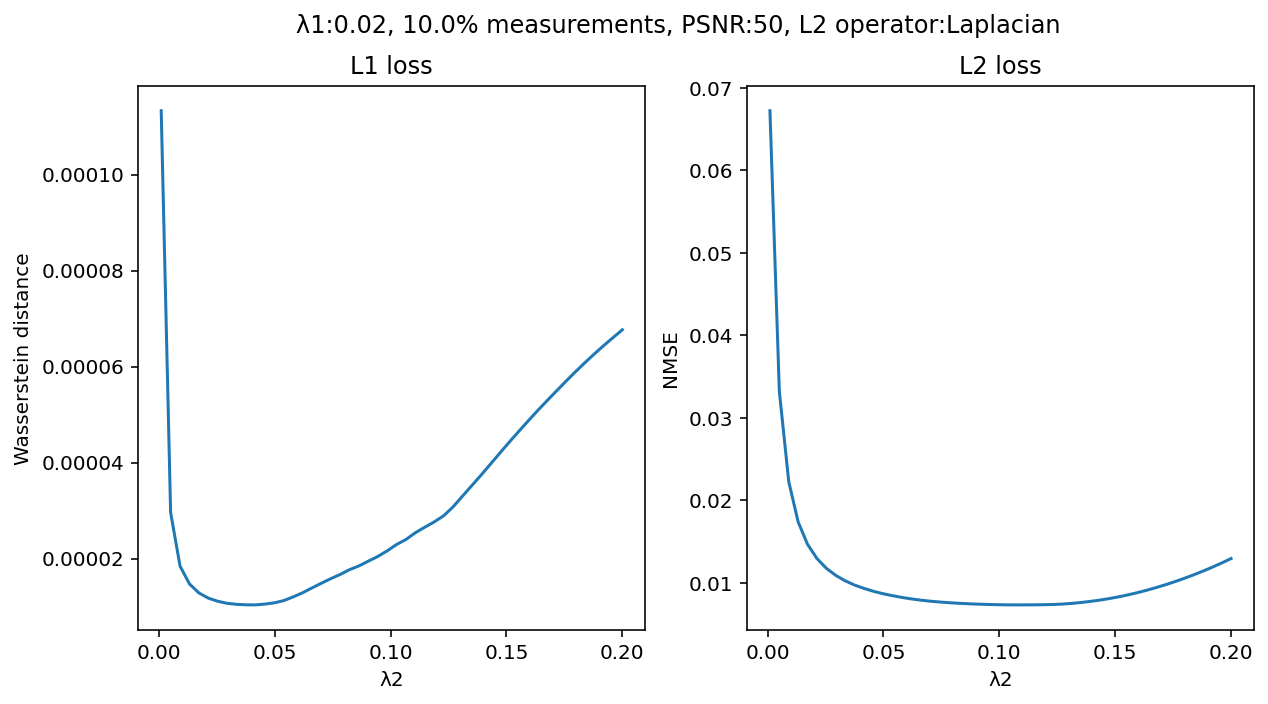

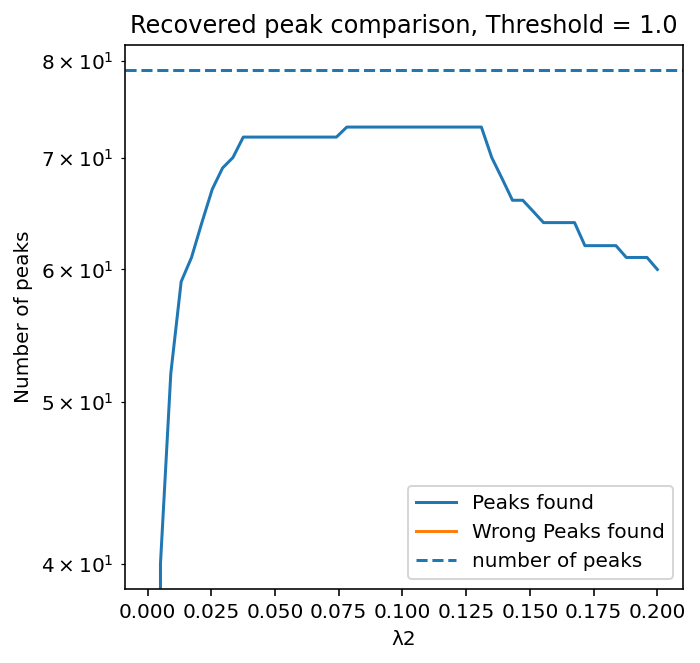

In [12]:
test_lambda2(s, L, lambda2_min=0.001, lambda2_max=0.2, nb=50, lambda1=0.02, operator_l2="Laplacian", psnr=50.)

Peaks found : 46
Wrong peaks found : 214


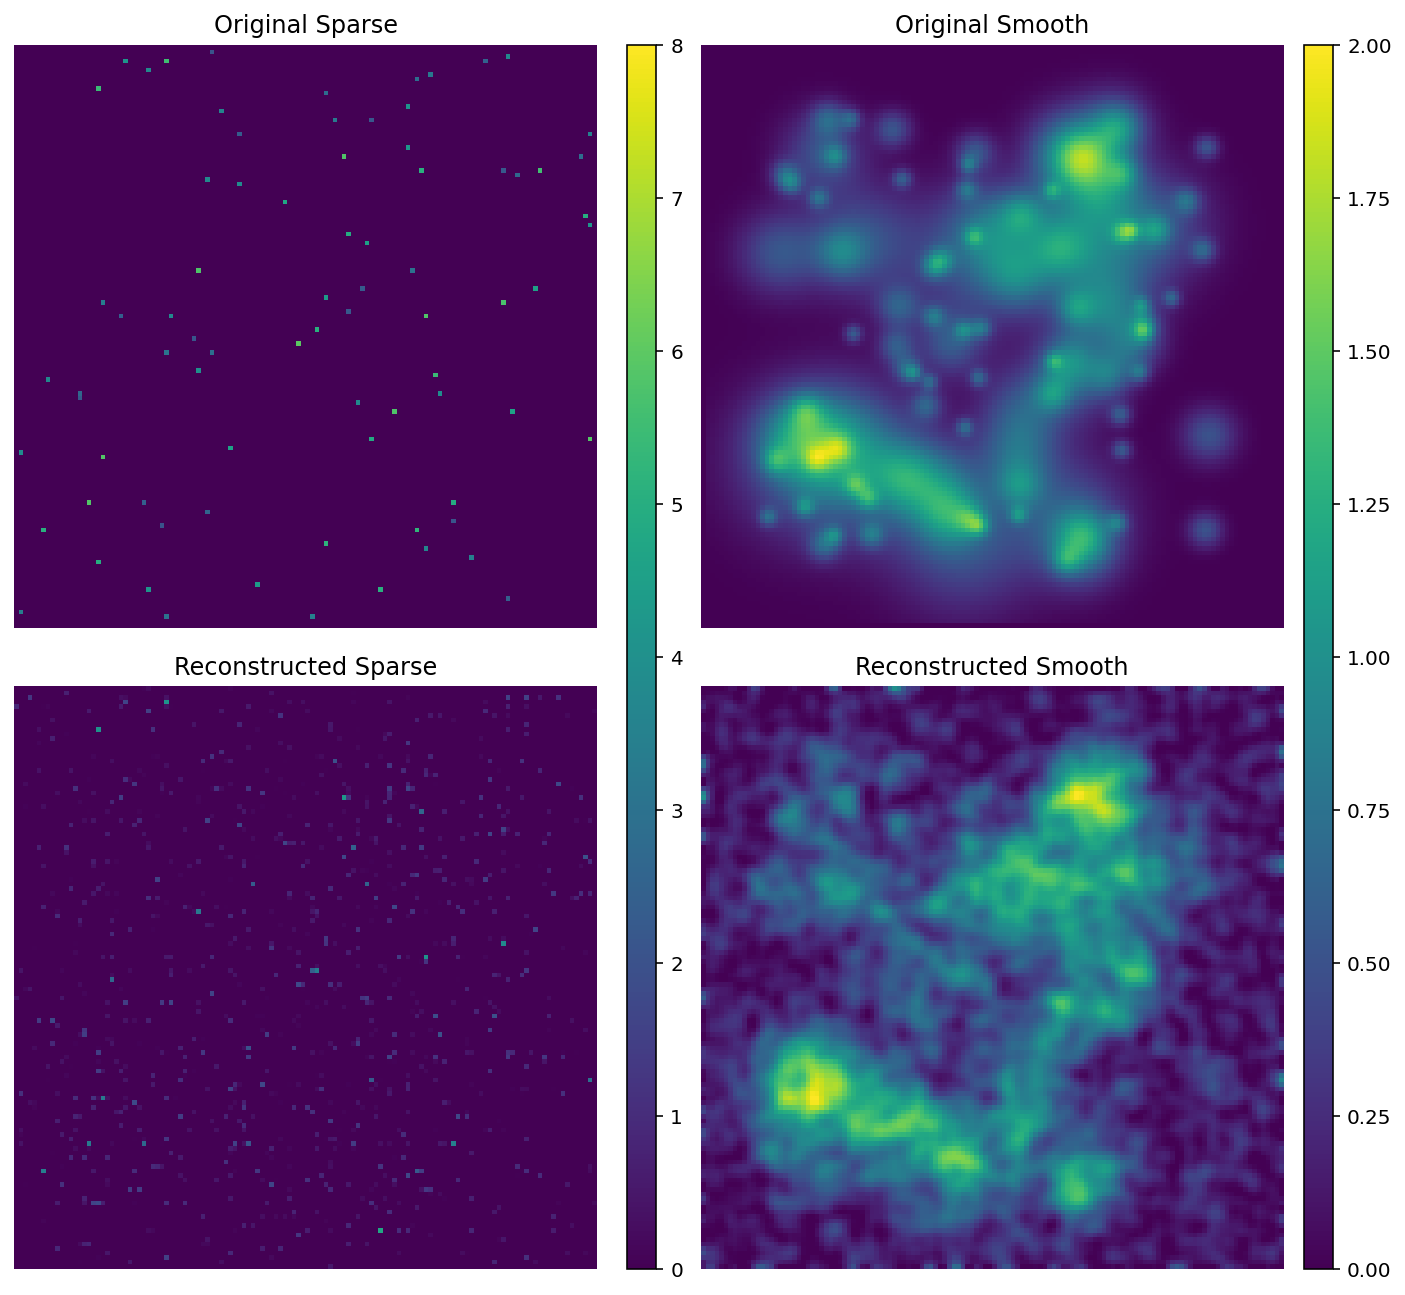

In [13]:
s.psnr = 30.
x1, x2 = solve(s, l1, l2, get_L2_operator(d, "Laplacian"))
plot_reconstruction(s.sparse, s.smooth, x1, x2)
found, wrong =  peaks_found(s.sparse, x1, 0.75)
print(f"Peaks found : {found}")
print(f"Wrong peaks found : {wrong}")

eaks found : 17
rong peaks found : 918


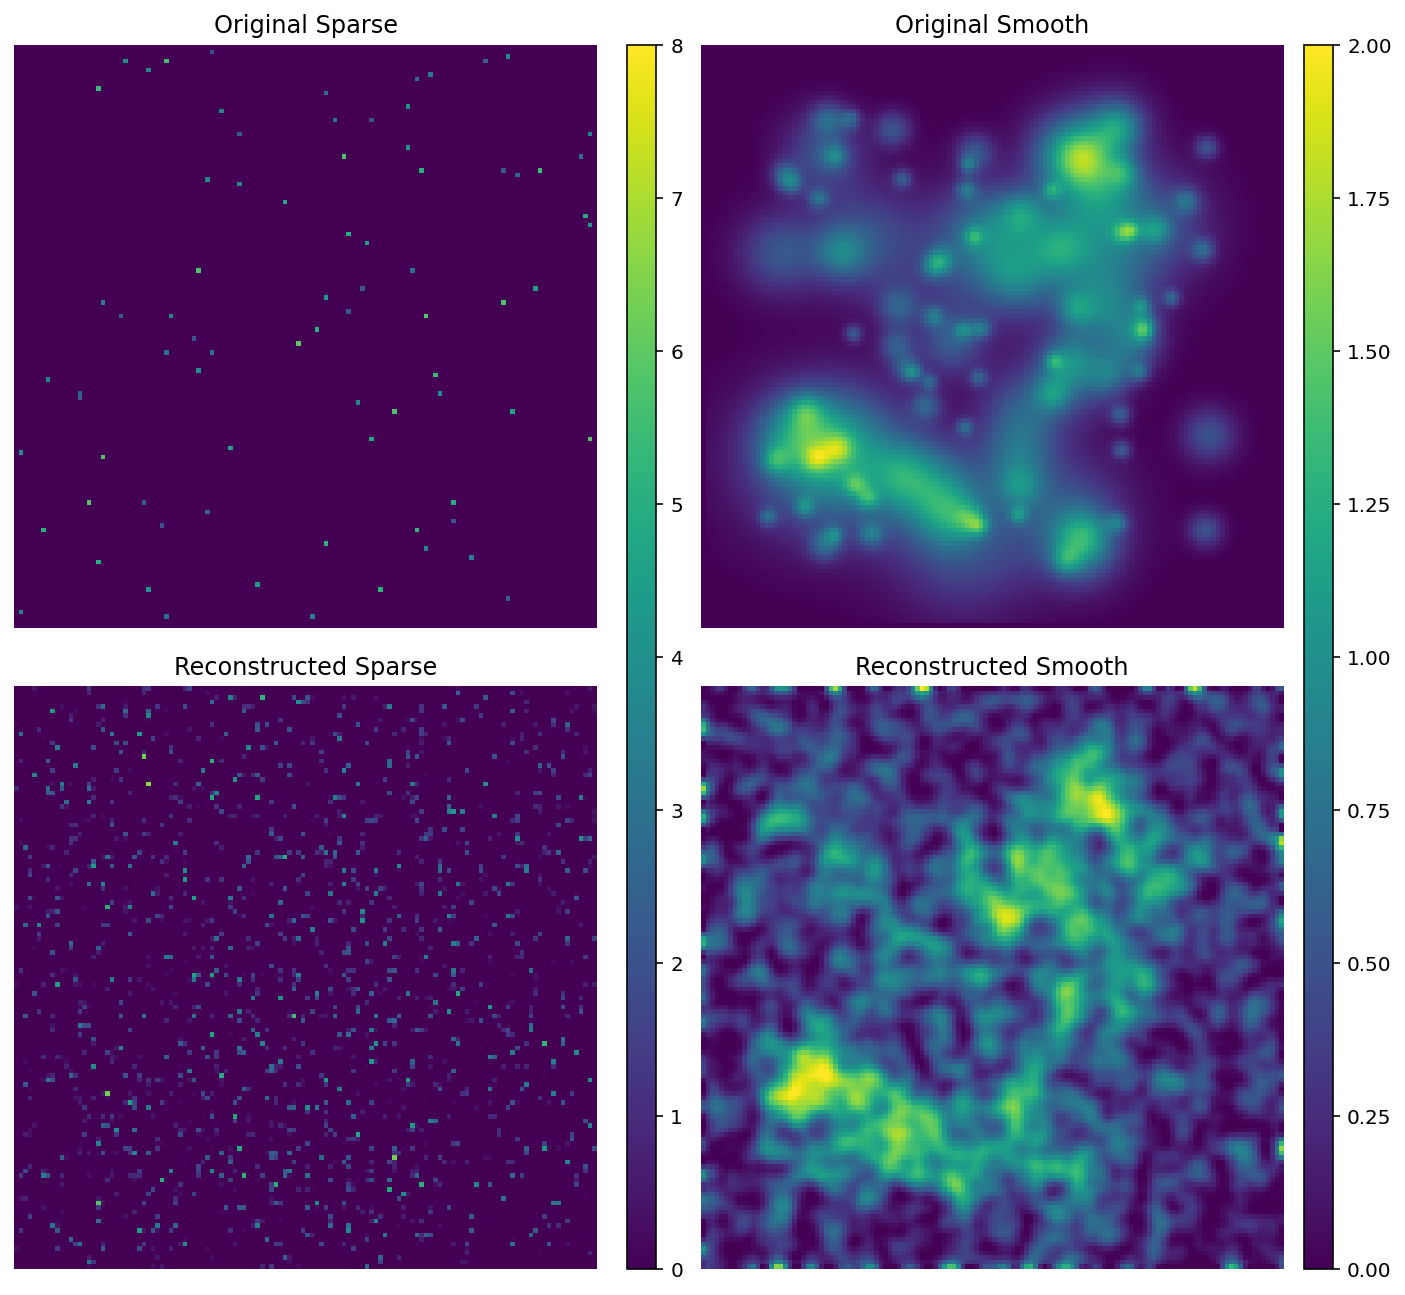

In [14]:
psnr = 20.
s.psnr = psnr
x1, x2 = solve(s, l1, l2, get_L2_operator(d, "Laplacian"))
plot_reconstruction(s.sparse, s.smooth, x1, x2)
found, wrong = peaks_found(s.sparse, x1, 0.75)
print(f"peaks found : {found}")
print(f"wrong peaks found : {wrong}")

Best value for L1 penalty: 0.2
Best value for L2 penalty: 0.017244897959183676


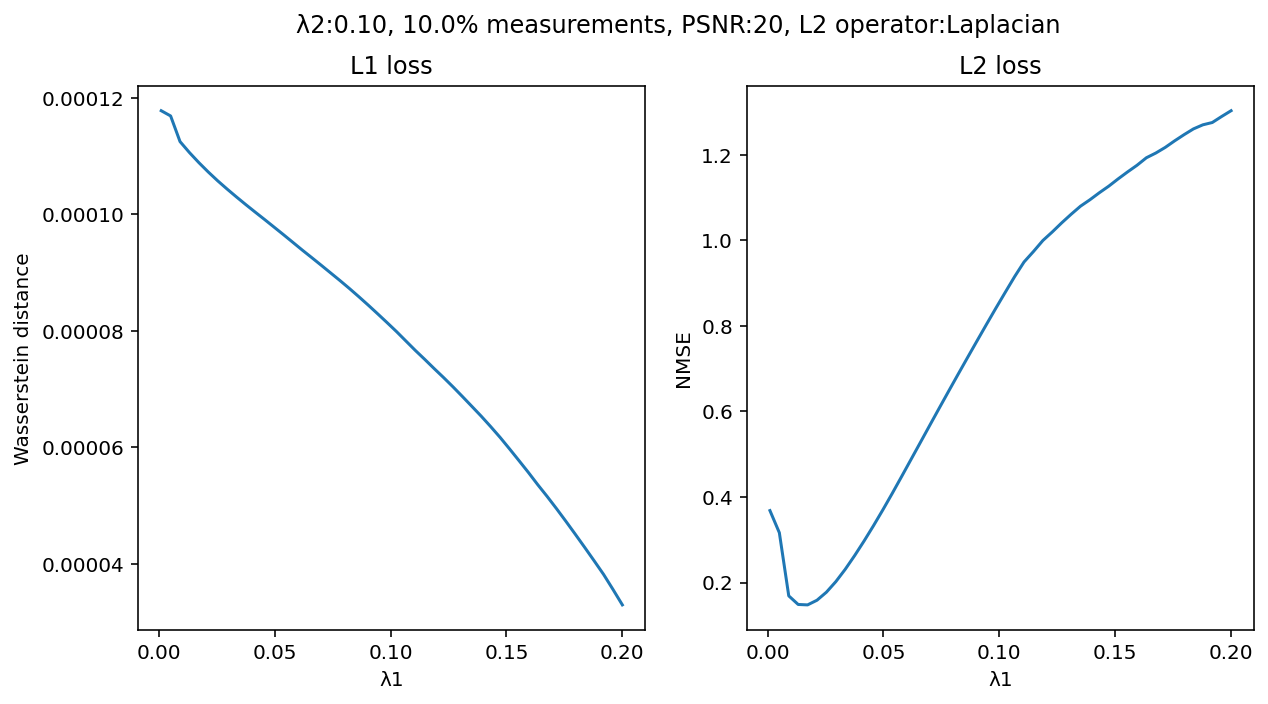

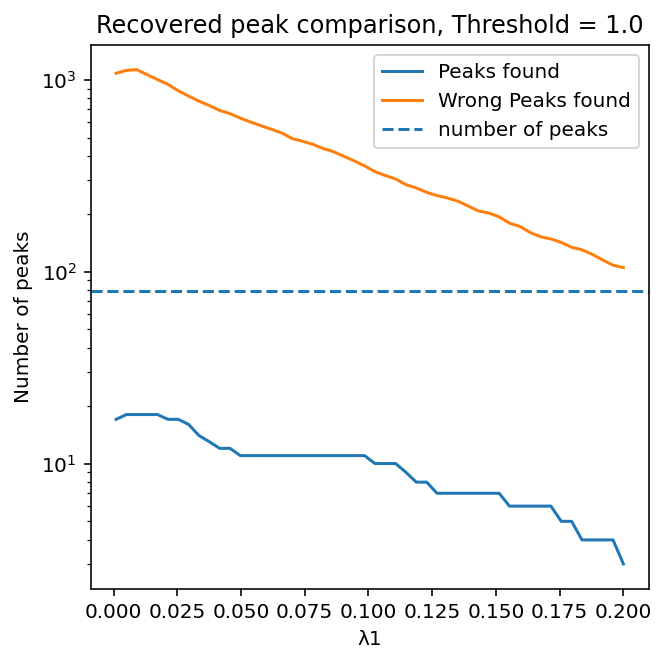

In [15]:
test_lambda1(s, L, lambda1_min=0.001, lambda1_max=0.2, nb=50, lambda2=0.1, operator_l2="Laplacian", psnr=psnr)

Best value L1: 0.005061224489795919
Best value L2: 0.2


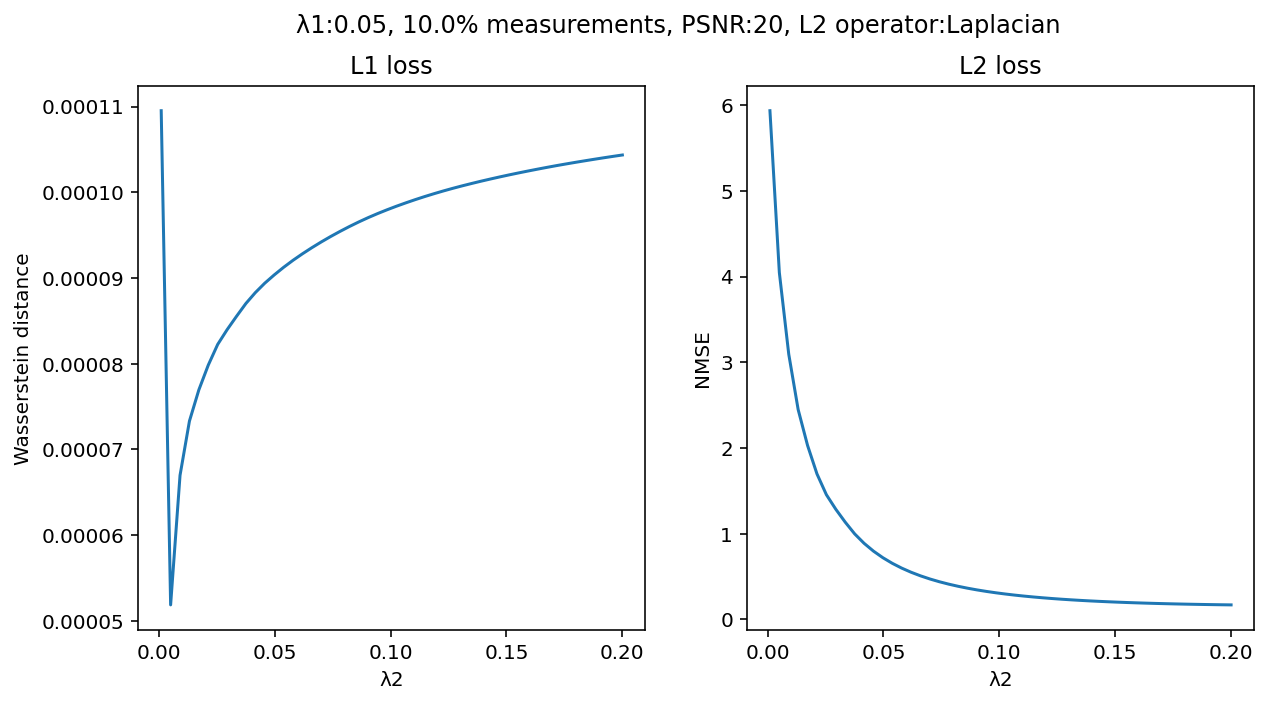

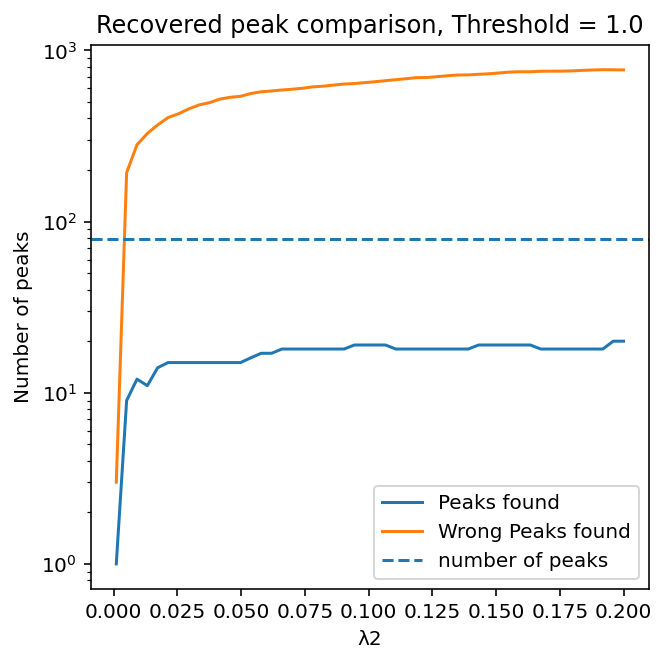

In [16]:
test_lambda2(s, L, lambda2_min=0.001, lambda2_max=0.2, nb=50, lambda1=0.05, operator_l2="Laplacian", psnr=psnr)